In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import utils

C:\Users\msubr\Anaconda3\envs\bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv("../data/UCF-crime-frames-descriptions-partitions.csv")

In [4]:
data.head(2)

,Unnamed: 0,frame,directory,class,Description,partition
0,0,Abuse001_x264.mp4_frame_000000.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train
1,1,Abuse001_x264.mp4_frame_000010.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train


In [5]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]
test = data.loc[data["partition"] == "test"]

In [7]:
X = np.load("../data/train_qformer.npy")
V = np.load("../data/val_qformer.npy")
X = torch.tensor(X, dtype=torch.float32)
V = torch.tensor(V, dtype=torch.float32)
y = list(train["class"])
y = np.array([utils.labels[lbl] for lbl in y])
y = torch.tensor(y, dtype=torch.float32)
y_val = list(val["class"])
y_val = np.array([utils.labels[lbl] for lbl in y_val])
y_val = torch.tensor(y_val, dtype=torch.float32)

In [9]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(utils.labels))])
weights = 1 - labels_counts / len(X)    

In [10]:
model = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [11]:
sum(param.numel() for param in model.parameters())

462346

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

In [13]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [14]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += utils.get_acc(y_pred, ybatch, return_sum=True)
    val_pred = utils.evaluate(V, model, device, batch_size)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {utils.get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 1.4557346105575562, acc 0.6837166547775269 val_acc 0.6604242324829102
Finished epoch 1, latest loss 0.9920542240142822, acc 0.7198759913444519 val_acc 0.6517330408096313
Finished epoch 2, latest loss 0.6769895553588867, acc 0.7498167753219604 val_acc 0.6576306223869324
Finished epoch 3, latest loss 1.1439563035964966, acc 0.7589512467384338 val_acc 0.6571650505065918
Finished epoch 4, latest loss 1.2071453332901, acc 0.7709291577339172 val_acc 0.6421624422073364
Finished epoch 5, latest loss 0.6959408521652222, acc 0.7800878286361694 val_acc 0.6169684529304504
Finished epoch 6, latest loss 0.6345231533050537, acc 0.7899714112281799 val_acc 0.6170201897621155
Finished epoch 7, latest loss 0.9105778932571411, acc 0.8003222346305847 val_acc 0.6101914048194885
Finished epoch 8, latest loss 0.8108032941818237, acc 0.8072576522827148 val_acc 0.6356440782546997
Finished epoch 9, latest loss 0.5200809836387634, acc 0.8139031529426575 val_acc 0.6206414699554443
Fin

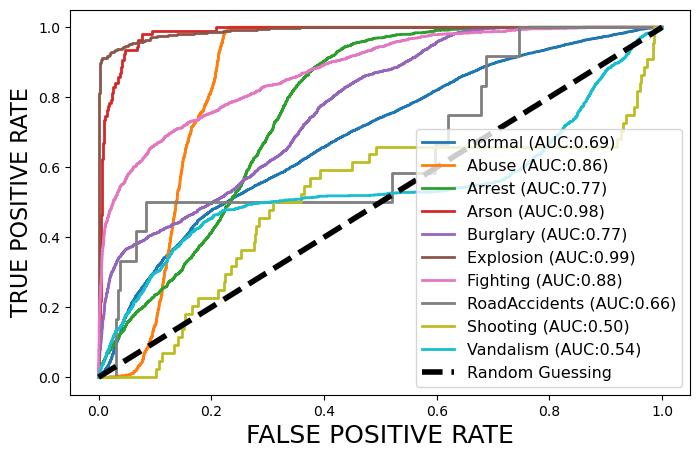

ROC AUC score: 0.7649920975627675


In [15]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

In [16]:
utils.get_acc_per_lbl(val_pred, y_val)

0, presc 0.73, recall 0.82, f1 0.77	 total 12895 Normal
1, presc 0.20, recall 0.46, f1 0.28	 total 646 Abuse
2, presc 0.66, recall 0.09, f1 0.16	 total 1321 Arrest
3, presc 0.28, recall 0.80, f1 0.42	 total 106 Arson
4, presc 0.34, recall 0.21, f1 0.26	 total 1767 Burglary
5, presc 0.99, recall 0.72, f1 0.83	 total 388 Explosion
6, presc 0.42, recall 0.33, f1 0.37	 total 1132 Fighting
7, presc nan, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc 0.01, recall 0.02, f1 0.02	 total 44 Shooting
9, presc 0.29, recall 0.14, f1 0.19	 total 1019 Vandalism


In [17]:
utils.get_acc(val_pred, y_val)

tensor(0.6316)

In [21]:
X_pred = utils.evaluate(X, model, device, batch_size)

In [22]:
utils.get_acc_per_lbl(X_pred, y)

0, presc 0.94, recall 0.87, f1 0.91	 total 84684 Normal
1, presc 0.56, recall 0.67, f1 0.61	 total 2593 Abuse
2, presc 0.87, recall 0.96, f1 0.91	 total 10454 Arrest
3, presc 0.76, recall 0.92, f1 0.83	 total 4984 Arson
4, presc 0.80, recall 0.96, f1 0.87	 total 8211 Burglary
5, presc 0.74, recall 0.82, f1 0.77	 total 2138 Explosion
6, presc 0.66, recall 0.87, f1 0.75	 total 6178 Fighting
7, presc 0.37, recall 0.01, f1 0.02	 total 689 RoadAccidents
8, presc 0.47, recall 0.40, f1 0.43	 total 1568 Shooting
9, presc 0.68, recall 0.77, f1 0.72	 total 2646 Vandalism


In [23]:
utils.get_acc(X_pred, y)

tensor(0.8698)

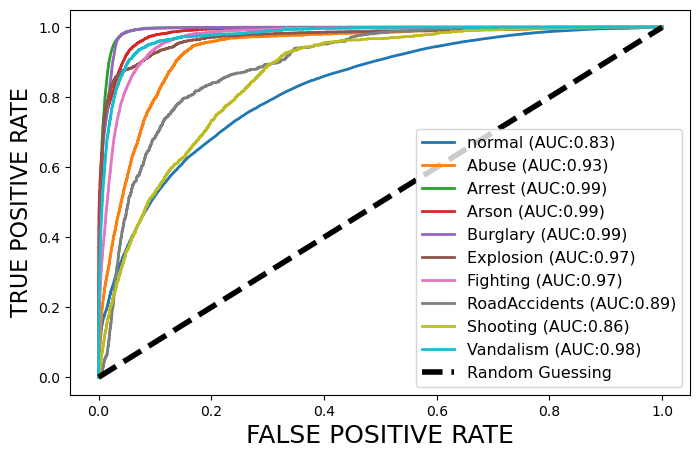

ROC AUC score: 0.9402803543478946


In [24]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y , X_pred, average = "macro"))

In [25]:
torch.save(model.state_dict(), "models/model_image_qformer_features.pt")